<a href="https://colab.research.google.com/github/Anastas1aMakarova/Machine-Learning/blob/main/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation


In [ ]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

## Подключение библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab
### Подгрузка данных## Подключение библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

### Подгрузка данных

In [ ]:
with open('data.txt', encoding='utf-8') as f:
    print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### BPE

In [ ]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [ ]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))
with open('train.en', 'w', encoding='utf-8') as f_src,  open('train.ru', 'w', encoding='utf-8') as f_dst:
  for line in open('data.txt',  encoding='utf-8'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [ ]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang, encoding='utf-8'), open('bpe_rules.' + lang, 'w', encoding='utf-8'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang, encoding='utf-8'))

    with open('train.bpe.' + lang, 'w', encoding='utf-8') as f_out:
        for line in open('train.' + lang, encoding='utf-8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:11<00:00, 715.84it/s]


### Построение словарей


In [ ]:
data_inp = np.array(open('./train.bpe.ru', encoding='utf-8').read().split('\n'))
data_out = np.array(open('./train.bpe.en', encoding='utf-8').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,### Построение словарей

)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



In [ ]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 1833, 8034,   59, 3799,   29,    1],
        [   0, 6028, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1869,   29,    1,    1,    1,    1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


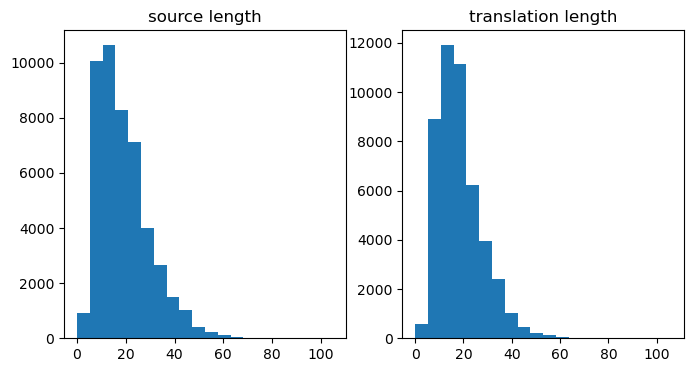

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):

        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):

        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):

        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):

        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state

        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [ ]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
train_inp[:3]

array(['этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .',
       'на полностью оборудованной мини - кухне можно самостоятельно готовить .',
       'номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .'],
      dtype='<U524')

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
reis coastal sporting veni@@ que@@ veni@@ locanda woods woods billiards cang@@ ys motor@@ rote glac@@ qiao gual jord@@ friends temp@@ und giovanni rela@@ according alo@@
attoria roof sophi@@ them them them arti@@ tren@@ nes sibir@@ dorms cristobal apol@@ apol@@ pollen@@ atm zimmer nights nights zhen aca alex pack@@ vis@@ am
reis coastal sporting veni@@ que@@ veni@@ locanda woods woods billiards cang@@ ys motor@@ rote glac@@ qiao gual jord@@ friends temp@@ und giovanni rela@@ according alo@@


### Loss

In [ ]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5258, grad_fn=<NegBackward0>)


### Оценка качества: BLEU

In [ ]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.001527445446701324

### Training loop

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

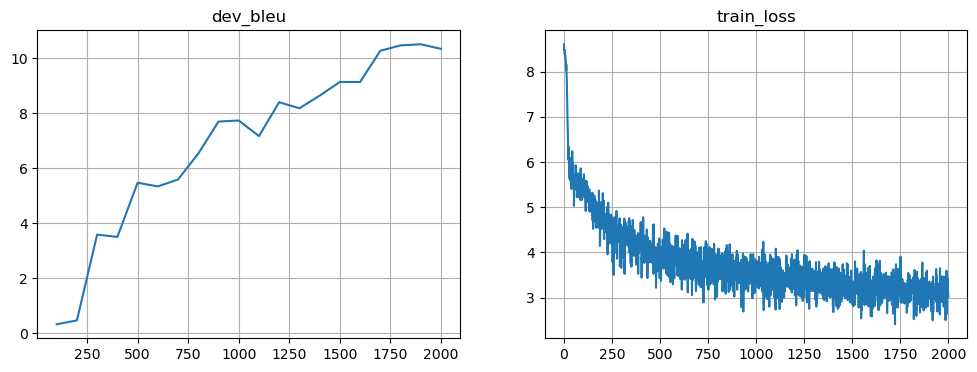

Mean loss=3.151


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [15:53<00:00,  2.10it/s]


In [ ]:
for _ in trange(2000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

AssertionError: We kind of need a higher bleu BLEU from you. Kind of right now.

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the private bathroom comes with a bath or shower .

на территории можно сыграть в дартс и сквош .
guests can enjoy a drink at the property .

апартаменты располагают гостиной зоной .
the accommodation is fitted with a dishwasher .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
a microwave and a coffee machine are also available .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the apartment comes with a tv , a seating area and a seating area with a seating area and a seating area .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the hotel ’ s restaurant serves a variety of activities can be enjoyed on site .



In [ ]:
compute_bleu(model, dev_inp, dev_out)

10.348337721699732

### Attention

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention


In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128, dropout_prob=0.5): # Добавим аргумент dropout_prob
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.dropout_prob = dropout_prob  # Добавим атрибут dropout_prob

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dropout = nn.Dropout(dropout_prob)  # Добавим dropout

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)

        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        dec_start = self.dropout(dec_start)

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)

        x = self.dropout(x)

        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]

    def decode_inference(self, initial_state, max_len=100, beam_size=5, **flags):
        """ Generate translations from model (beam search version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]

        all_states = [initial_state]

        for i in range(max_len):
            all_candidates = []
            for output in outputs:
                state, logits = self.decode_step(state, output)
                logprobs = F.log_softmax(logits, dim=-1)

                top_probs, top_ix = torch.topk(logprobs[:, -1, :], k=beam_size, dim=-1)

                for prob, ix in zip(top_probs.split(1, dim=-1), top_ix.split(1, dim=-1)):
                    candidate = (output, state, -prob.item(), ix.item())
                    all_candidates.append(candidate)

            ordered_candidates = sorted(all_candidates, key=lambda x: x[2])
            outputs = [torch.cat((output, candidate[3].view(-1)), dim=-1) for output, _, _, candidate in ordered_candidates[:beam_size]]
            all_states.extend([candidate[1] for _, candidate in zip(ordered_candidates[:beam_size])])

        return torch.stack(outputs, dim=1), all_states

In [ ]:
dummy_inp_tokens_beam = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens_beam = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)
dummy_initial_state = model.encode(dummy_inp_tokens_beam)
# beam search
dummy_translations_beam, dummy_states_beam = model.decode_inference(dummy_initial_state, max_len=25, beam_size=3)
print("Translations with beam search:")
print('\n'.join([line for line in model.out_voc.to_lines(dummy_translations_beam.cpu().numpy())]))

Translations with beam search:
the property offers a restaurant .
the property offers a shared kitchen .
the nearest airport is 12 km from the property .
there is a shared kitchen .
the property also offers a shared kitchen .


### Training loop - модель с Attention


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.002392409277551994

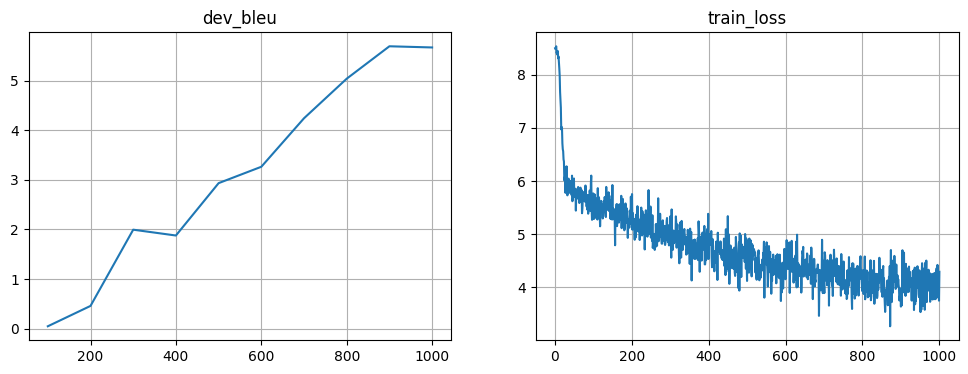

Mean loss=4.115


100%|██████████| 1000/1000 [37:48<00:00,  2.27s/it]


In [ ]:
for _ in trange(1000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

10.966114597790376

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()


в ванной комнате с ванной предоставляется фен .
the private bathroom comes with a shower . 

на территории можно сыграть в дартс и сквош .
the property offers free drinks .

nапартаменты располагают гостиной зоной .
the accommodation provides a free dishes ..

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can enjoy a microwave and a free drinks .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the apartment has a tv , a tv and a recreation area with a recreation area and a recreation area .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the hotel ’ s restaurant serves a variety of motions at the site .
